In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Experiment of Predicting The Contribution of a Player 
Oyuncu bazlı veride düşük accuracy almamız çok normal, çünkü voleybol takım oyunu: bir oyuncu, çok iyi performans gösterdiği halde takım maçı kaybedebilir veya çok kötü performans gösterdiği halde takım maçı kazanabilir. O yüzden oyuncunun performasını kullanarak maç sonucunu tamin etmek yerine oyuncunun takıma katkısını tahmin edelim. Çünkü bu değer her oyuncu için bireysel bir değer, maç sonucu gibi kolektif oluşturulan bir değer değil. Regresyon ile oyuncuların tüm özelliklerini tahmin etmeye çalışacağız.

Verimizdeki bir oyuncu gözümüze çarptı, FGCU (ASUN) takımından Lockey, Chelsey. 11/22/2019 tarihinde girdiği voleybol maçında 0.0 kill fakat 52.0 asist puanı var. Bu oyuncu, takımın kazandığı 52 sayıya yardım etmiş. 
### Calculate Contribution of a Player

In [2]:
# load the data
team_df= pd.read_parquet('parquet_data/team_df_missing_handled.parquet')
player_df= pd.read_parquet('parquet_data/player_df_undersampled.parquet')# player veri seti ile team veri setini 'name' (team_name yerine) ve 'Date' kolonları üzerinden birleştirin

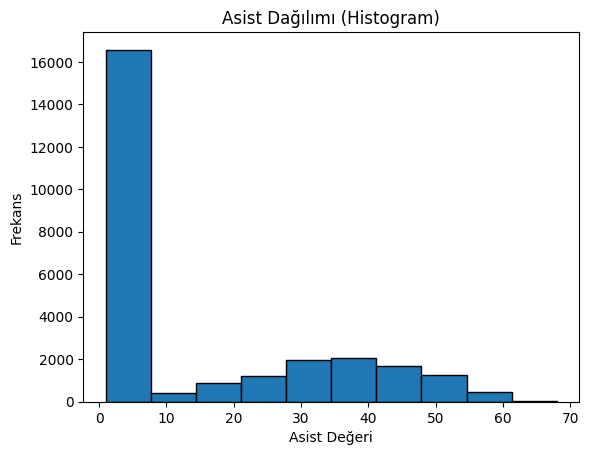

In [3]:
# Histogram çizme
#player_df['Assists'] = np.log1p(player_df['Assists'])  # log(assists + 1) dönüşümü
#team_df['Assists'] = np.log1p(team_df['Assists'])  # log(assists + 1) dönüşümü
plt.hist(player_df['Assists'], bins=10, edgecolor='black')
plt.title('Asist Dağılımı (Histogram)')
plt.xlabel('Asist Değeri')
plt.ylabel('Frekans')
plt.show()

Logarithmic conversion: Converting the assist values logarithmically can achieve a smoother distribution by compressing excessively high values. Thus, our model can learn the assist column well.

In [4]:
# Eğer tarih formatı 'dd/mm/yyyy' ise
player_df['Date'] = pd.to_datetime(player_df['Date'], format='%m/%d/%Y')
team_df['Date'] = pd.to_datetime(team_df['Date'], format='%m/%d/%Y')

In [5]:
# Team_df'teki duplicaleri droplayalım
grouped = team_df.groupby(['name', 'Date', 'Opponent'])
# Her grup için eleman sayısı
group_sizes = grouped.size()
two_element_groups = group_sizes[group_sizes == 2]

# 2 elemanlı grupların içerdiği indeksleri bulma
# grouped.indices bu grupların indekslerini döndürür
two_element_indices = [index for group in two_element_groups.index for index in grouped.get_group(group).index]

# Orijinal veri setinden bu indeksleri drop etme
team_df_dropped = team_df.drop(two_element_indices)

In [6]:
# find the matches that the player is playing from tema_df
merged_data = pd.merge(player_df, team_df_dropped, 
                       left_on=['team_name', 'Date', 'Opponent'], 
                       right_on=['name', 'Date', 'Opponent'], 
                       how='left')

In [7]:
player_df

,Date,Opponent,Result,S,Kills,Errors,Total Attacks,Hit Pct,Assists,SErr,Digs,Block Assists,PTS,name,team_name
0,2016-09-17,@ Yale,L 1 - 3,4.0,14.0,3.0,37.0,0.297,3.0,1.0,5.0,3.0,16.5,"Carlson, Morgan",A&M-Corpus Christi (Southland)
1,2016-10-11,@ UTRGV,L 2 - 3,5.0,8.0,1.0,20.0,0.350,2.0,3.0,1.0,6.0,11.0,"Doud, Madeleine",A&M-Corpus Christi (Southland)
2,2016-10-11,@ UTRGV,L 2 - 3,5.0,11.0,6.0,44.0,0.114,3.0,1.0,17.0,3.0,12.5,"Gilpin, Brittany",A&M-Corpus Christi (Southland)
3,2016-12-02,@ Washington,L 0 - 3,3.0,5.0,4.0,30.0,0.033,2.0,1.0,5.0,1.0,5.5,"Gilpin, Brittany",A&M-Corpus Christi (Southland)
4,2016-09-03,"San Diego @ Madison, Wis.",L 0 - 3,3.0,3.0,1.0,7.0,0.286,19.0,1.0,3.0,3.0,4.5,"Nicholson, Kristyn",A&M-Corpus Christi (Southland)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26525,2019-11-22,Lipscomb,W 3 - 1,4.0,0.0,1.0,7.0,-0.143,52.0,1.0,8.0,1.0,2.5,"Lockey, Chelsey",FGCU (ASUN)
26526,2018-08-24,UMass Lowell,W 3 - 0,3.0,6.0,1.0,14.0,0.357,2.0,2.0,2.0,2.0,10.0,"Fezzey, Tyler",Cal St. Fullerton (Big West)
26527,2016-09-13,@ Loyola Chicago,W 3 - 1,4.0,13.0,2.0,40.0,0.275,2.0,4.0,6.0,1.0,13.5,"Ehrhardt, Alyssa",UIC (Horizon)
26528,2018-09-14,"Murray St. @ St. Louis, Mo.",W 3 - 1,4.0,0.0,1.0,1.0,-1.000,41.0,2.0,6.0,1.0,0.5,"Rolda, Antonette",UNLV (MWC)


In [8]:
pd.set_option('display.max_columns', None)
merged_data

,Date,Opponent,Result_x,S_x,Kills_x,Errors_x,Total Attacks_x,Hit Pct_x,Assists_x,SErr_x,Digs_x,Block Assists_x,PTS_x,name_x,team_name,Result_y,S_y,Kills_y,Errors_y,Total Attacks_y,Hit Pct_y,Assists_y,Aces,SErr_y,Digs_y,RErr,Block Assists_y,PTS_y,name_y
0,2016-09-17,@ Yale,L 1 - 3,4.0,14.0,3.0,37.0,0.297,3.0,1.0,5.0,3.0,16.5,"Carlson, Morgan",A&M-Corpus Christi (Southland),L 1 - 3,4.0,44.0,24.0,143.0,0.140,38.0,3.0,4.0,56.0,6.0,18.0,57.0,A&M-Corpus Christi (Southland)
1,2016-10-11,@ UTRGV,L 2 - 3,5.0,8.0,1.0,20.0,0.350,2.0,3.0,1.0,6.0,11.0,"Doud, Madeleine",A&M-Corpus Christi (Southland),L 2 - 3,5.0,60.0,26.0,187.0,0.182,57.0,2.0,6.0,77.0,6.0,26.0,76.0,A&M-Corpus Christi (Southland)
2,2016-10-11,@ UTRGV,L 2 - 3,5.0,11.0,6.0,44.0,0.114,3.0,1.0,17.0,3.0,12.5,"Gilpin, Brittany",A&M-Corpus Christi (Southland),L 2 - 3,5.0,60.0,26.0,187.0,0.182,57.0,2.0,6.0,77.0,6.0,26.0,76.0,A&M-Corpus Christi (Southland)
3,2016-12-02,@ Washington,L 0 - 3,3.0,5.0,4.0,30.0,0.033,2.0,1.0,5.0,1.0,5.5,"Gilpin, Brittany",A&M-Corpus Christi (Southland),L 0 - 3,3.0,29.0,22.0,104.0,0.067,28.0,1.0,7.0,37.0,9.0,6.0,34.0,A&M-Corpus Christi (Southland)
4,2016-09-03,"San Diego @ Madison, Wis.",L 0 - 3,3.0,3.0,1.0,7.0,0.286,19.0,1.0,3.0,3.0,4.5,"Nicholson, Kristyn",A&M-Corpus Christi (Southland),L 0 - 3,3.0,30.0,16.0,94.0,0.149,29.0,1.0,3.0,32.0,1.0,15.0,42.5,A&M-Corpus Christi (Southland)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26525,2019-11-22,Lipscomb,W 3 - 1,4.0,0.0,1.0,7.0,-0.143,52.0,1.0,8.0,1.0,2.5,"Lockey, Chelsey",FGCU (ASUN),W 3 - 1,4.0,55.0,14.0,160.0,0.256,53.0,3.0,8.0,71.0,5.0,22.0,71.0,FGCU (ASUN)
26526,2018-08-24,UMass Lowell,W 3 - 0,3.0,6.0,1.0,14.0,0.357,2.0,2.0,2.0,2.0,10.0,"Fezzey, Tyler",Cal St. Fullerton (Big West),W 3 - 0,3.0,40.0,16.0,107.0,0.224,36.0,8.0,6.0,51.0,4.0,14.0,56.0,Cal St. Fullerton (Big West)
26527,2016-09-13,@ Loyola Chicago,W 3 - 1,4.0,13.0,2.0,40.0,0.275,2.0,4.0,6.0,1.0,13.5,"Ehrhardt, Alyssa",UIC (Horizon),W 3 - 1,4.0,52.0,18.0,135.0,0.252,50.0,3.0,10.0,51.0,2.0,16.0,65.0,UIC (Horizon)
26528,2018-09-14,"Murray St. @ St. Louis, Mo.",W 3 - 1,4.0,0.0,1.0,1.0,-1.000,41.0,2.0,6.0,1.0,0.5,"Rolda, Antonette",UNLV (MWC),W 3 - 1,4.0,47.0,11.0,130.0,0.277,44.0,12.0,17.0,67.0,4.0,6.0,65.0,UNLV (MWC)


In [9]:
# Let's calculate the performance rates
merged_data['Kill_ratio'] = 100*(merged_data['Kills_x'] / merged_data['Kills_y'])
merged_data['Errors_ratio'] =100*( merged_data['Errors_x'] / merged_data['Errors_y'])
#merged_data['Hit_pct_ratio'] = merged_data['Hit Pct_x'] / merged_data['Hit Pct_y'] # hit_pct_ is already a rate
merged_data['Assists_ratio'] =100*( merged_data['Assists_x'] / merged_data['Assists_y'])
merged_data['Total Attacks_ratio'] =100*( merged_data['Total Attacks_x'] / merged_data['Total Attacks_y'])
merged_data['PTS_ratio'] = 100*(merged_data['PTS_x'] / merged_data['PTS_y'])
merged_data['SErr_ratio'] = 100*(merged_data['SErr_x'] / merged_data['SErr_y'])
merged_data['Digs_ratio'] = 100*(merged_data['Digs_x'] / merged_data['Digs_y'])
merged_data['Block Assists_ratio'] = 100*(merged_data['Block Assists_x'] / merged_data['Block Assists_y'])
#merged_data['S_ratio'] = merged_data['S_x'] / merged_data['S_y'] # don't need to calculate rate of set column

In [10]:
# Create the new data set and select the necessary columns (select the columns that in player data set)
player_performance_ratios = merged_data[['Date','Opponent','Result_x','S_x', 'Kill_ratio', 'Errors_ratio', 'Total Attacks_ratio','Hit Pct_x', 'Assists_ratio', 
                                         'SErr_ratio', 'Digs_ratio', 'Block Assists_ratio', 
                                         'PTS_ratio', 'name_x','name_y']]

In [11]:
rows_to_drop = player_performance_ratios[player_performance_ratios.isnull().any(axis=1)].index
# Drop the corresponding rows in the player_df dataset
player_df_cleaned = player_df.drop(rows_to_drop)

player_performance_ratios = player_performance_ratios.dropna() # drop null rows (there is matches which are in player dataset but not in team dataset)
player_performance_ratios = player_performance_ratios.rename(columns={'name_x': 'name', 'name_y': 'team_name'})
player_performance_ratios

,Date,Opponent,Result_x,S_x,Kill_ratio,Errors_ratio,Total Attacks_ratio,Hit Pct_x,Assists_ratio,SErr_ratio,Digs_ratio,Block Assists_ratio,PTS_ratio,name,team_name
0,2016-09-17,@ Yale,L 1 - 3,4.0,31.818182,12.500000,25.874126,0.297,7.894737,25.000000,8.928571,16.666667,28.947368,"Carlson, Morgan",A&M-Corpus Christi (Southland)
1,2016-10-11,@ UTRGV,L 2 - 3,5.0,13.333333,3.846154,10.695187,0.350,3.508772,50.000000,1.298701,23.076923,14.473684,"Doud, Madeleine",A&M-Corpus Christi (Southland)
2,2016-10-11,@ UTRGV,L 2 - 3,5.0,18.333333,23.076923,23.529412,0.114,5.263158,16.666667,22.077922,11.538462,16.447368,"Gilpin, Brittany",A&M-Corpus Christi (Southland)
3,2016-12-02,@ Washington,L 0 - 3,3.0,17.241379,18.181818,28.846154,0.033,7.142857,14.285714,13.513514,16.666667,16.176471,"Gilpin, Brittany",A&M-Corpus Christi (Southland)
4,2016-09-03,"San Diego @ Madison, Wis.",L 0 - 3,3.0,10.000000,6.250000,7.446809,0.286,65.517241,33.333333,9.375000,20.000000,10.588235,"Nicholson, Kristyn",A&M-Corpus Christi (Southland)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26524,2016-10-09,Saint Peter's,W 3 - 0,3.0,13.157895,23.529412,16.842105,0.062,5.555556,16.666667,3.846154,25.000000,16.037736,"Ediger, Kelsey",Marist (MAAC)
26525,2019-11-22,Lipscomb,W 3 - 1,4.0,0.000000,7.142857,4.375000,-0.143,98.113208,12.500000,11.267606,4.545455,3.521127,"Lockey, Chelsey",FGCU (ASUN)
26526,2018-08-24,UMass Lowell,W 3 - 0,3.0,15.000000,6.250000,13.084112,0.357,5.555556,33.333333,3.921569,14.285714,17.857143,"Fezzey, Tyler",Cal St. Fullerton (Big West)
26527,2016-09-13,@ Loyola Chicago,W 3 - 1,4.0,25.000000,11.111111,29.629630,0.275,4.000000,40.000000,11.764706,6.250000,20.769231,"Ehrhardt, Alyssa",UIC (Horizon)


In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import numpy as np

target_columns = ['Kill_ratio','Errors_ratio','Total Attacks_ratio','Hit Pct_x','Assists_ratio','SErr_ratio','Digs_ratio','Block Assists_ratio','PTS_ratio']
# Verilerinizi hazırlayalım (Önceden temizlenmiş ve işlenmiş X ve y verisi)
player_df_columns =['Kills', 'Errors', 'Total Attacks',	'Hit Pct','Assists','SErr', 'Digs',	'Block Assists', 'PTS']

# Regression for Each Column and Try Different ML Models
### Firstly, Find the Optimal Number of Hidden Size Layer for MLP

In [13]:
from sklearn.neural_network import MLPRegressor

X_full = player_df_cleaned[player_df_columns]
hidden_layer_sizes_list = [
    (50,), (100,),(300,), (50, 50), (100, 50), (100, 100)
]

results = []

y_column = player_performance_ratios['Kill_ratio']
    
# X (özellikler) ve y (hedef) verilerini ayıralım
X = X_full.drop(columns=['Kills'])
    
# Veriyi normalize etme (SVM modelinin genellikle verilerin ölçeklenmesine ihtiyacı vardır)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
    
# Eğitim ve test verilerini bölelim
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_column, test_size=0.2, random_state=42)

for size in hidden_layer_sizes_list:

    
    # MLP Modeli
    model = MLPRegressor(hidden_layer_sizes=size, max_iter=1000, random_state=42)
    
    # Modeli eğit
    model.fit(X_train, y_train)
    
    # Test verisinde tahmin yap
    y_pred = model.predict(X_test)
    
    # Metrikleri hesapla
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Sonuçları sakla
    results.append({'hidden_layer_sizes': size, 'MSE': mse, 'R²': r2})

# Sonuçları DataFrame'e çevir
import pandas as pd
results_df = pd.DataFrame(results)
results_df.sort_values(by='MSE', inplace=True)

# Best sonucu göster
best_result = results_df.iloc[0]
print(f"Best yapı: {best_result['hidden_layer_sizes']}")
print(f"Best MSE: {best_result['MSE']:.4f}")
print(f"Best R²: {best_result['R²']:.4f}")

En iyi yapı: (100,)
En iyi MSE: 12.4121
En iyi R²: 0.8905


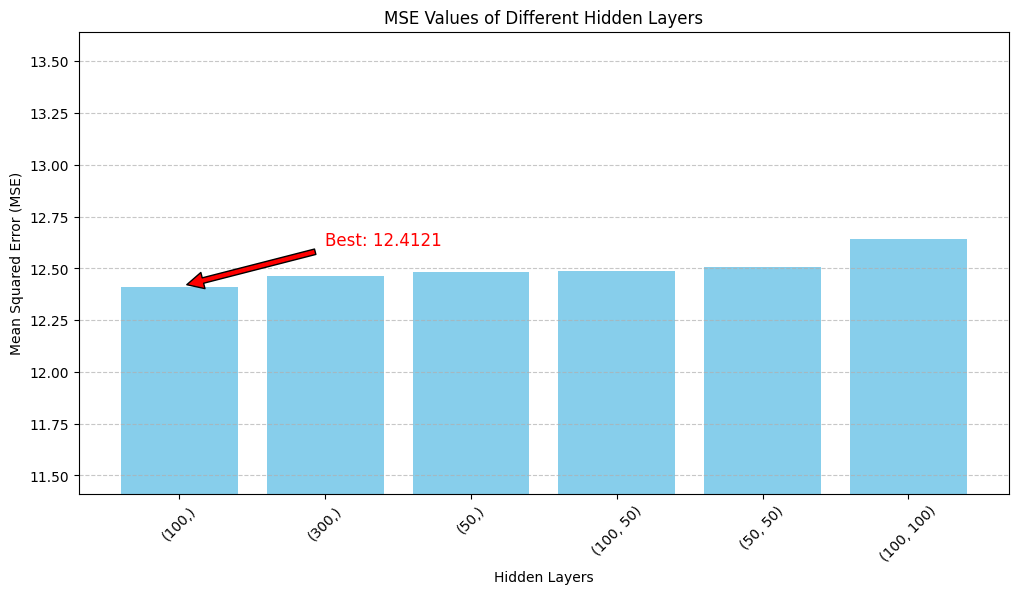

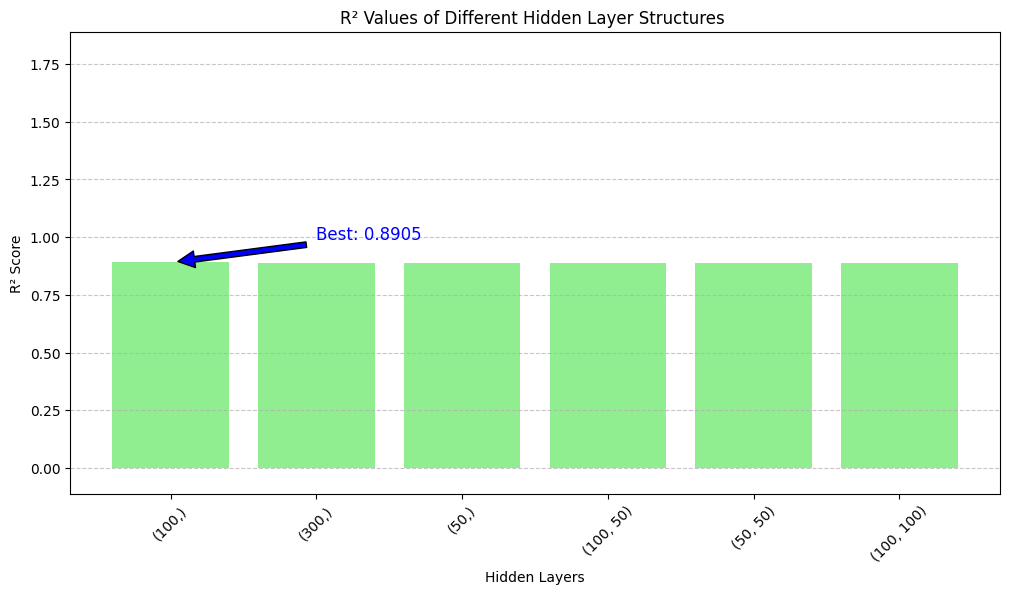

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(
    [str(size) for size in results_df_sorted['hidden_layer_sizes']],
    results_df_sorted['MSE'],
    color='skyblue'
)
plt.title("MSE Values of Different Hidden Layers")
plt.xlabel("Hidden Layers")
plt.ylabel("Mean Squared Error (MSE)")
plt.xticks(rotation=45)
plt.ylim(results_df_sorted['MSE'].min() - 1, results_df_sorted['MSE'].max() + 1)  # Y-ekseni aralığını daraltıyoruz
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Best sonucu işaretle
best_model = results_df_sorted.iloc[0]
plt.annotate(
    f"Best: {best_model['MSE']:.4f}",
    xy=(0, best_model['MSE']),
    xytext=(1, best_model['MSE'] + 0.2),
    arrowprops=dict(facecolor='red', shrink=0.05),
    fontsize=12,
    color='red'
)
plt.show()

# Çubuk grafik (R²)
plt.figure(figsize=(12, 6))
plt.bar(
    [str(size) for size in results_df_sorted['hidden_layer_sizes']],
    results_df_sorted['R²'],
    color='lightgreen'
)
plt.title("R² Values of Different Hidden Layer Structures ")
plt.xlabel("Hidden Layers")
plt.ylabel("R² Score")
plt.xticks(rotation=45)
plt.ylim(results_df_sorted['R²'].min() -1, results_df_sorted['R²'].max() + 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# En iyi sonucu işaretle
best_model = results_df_sorted.iloc[0]
plt.annotate(
    f"Best: {best_model['R²']:.4f}",
    xy=(0, best_model['R²']),
    xytext=(1, best_model['R²'] + 0.1),
    arrowprops=dict(facecolor='blue', shrink=0.05),
    fontsize=12,
    color='blue'
)
plt.show()

### PCA with Linear Regression

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
# Veriyi hazırlama
X_full = player_df_cleaned[player_df_columns]

for idx, column in enumerate(target_columns):
    y_column = player_performance_ratios[column]
    
    # X (özellikler) ve y (hedef) verilerini ayıralım
    X = X_full.drop(columns=[X_full.columns[idx]])

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # PCA ile boyut indirgeme (örneğin 3 ana bileşen seçelim)
    pca = PCA(n_components=8)
    X_pca = pca.fit_transform(X_scaled)
    
    # Eğitim ve test verilerini bölelim
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y_column, test_size=0.2, random_state=42)
    
    # Linear Regression modelini oluşturun
    model_pca_ratio = LinearRegression()
    
    # Modeli eğitelim
    model_pca_ratio.fit(X_train, y_train)
    
    # Test verisi üzerinde tahmin yapalım
    y_pred = model_pca_ratio.predict(X_test)
    
    # Model değerlendirme metriklerini hesaplayalım
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Sonuçları yazdıralım
    print(f"Değerlendirme sonuçları ({column} için):")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R²): {r2:.4f}")
    print("-" * 50)

Değerlendirme sonuçları (Kill_ratio için):
Mean Squared Error (MSE): 16.6568
Root Mean Squared Error (RMSE): 4.0813
Mean Absolute Error (MAE): 2.9554
R-squared (R²): 0.8530
--------------------------------------------------
Değerlendirme sonuçları (Errors_ratio için):
Mean Squared Error (MSE): 55.7829
Root Mean Squared Error (RMSE): 7.4688
Mean Absolute Error (MAE): 5.5705
R-squared (R²): 0.6420
--------------------------------------------------
Değerlendirme sonuçları (Total Attacks_ratio için):
Mean Squared Error (MSE): 17.2790
Root Mean Squared Error (RMSE): 4.1568
Mean Absolute Error (MAE): 3.1227
R-squared (R²): 0.8328
--------------------------------------------------
Değerlendirme sonuçları (Hit Pct_x için):
Mean Squared Error (MSE): 0.0310
Root Mean Squared Error (RMSE): 0.1760
Mean Absolute Error (MAE): 0.1006
R-squared (R²): 0.4517
--------------------------------------------------
Değerlendirme sonuçları (Assists_ratio için):
Mean Squared Error (MSE): 609.3507
Root Mean Squa

### Random Forest

In [32]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

X_full = player_df_cleaned[player_df_columns]

for idx, column in enumerate(target_columns):
    y_column = player_performance_ratios[column]
    
    # X (özellikler) ve y (hedef) verilerini ayıralım
    X = X_full.drop(columns=[X_full.columns[idx]])

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_column, test_size=0.2, random_state=42)

    # Random Forest modelini oluşturun ve eğitin
    model_random_original = RandomForestRegressor(n_estimators=100, random_state=42)
    model_random_original.fit(X_train, y_train)
    
    y_pred = model_random_original.predict(X_test)
    
    # Model değerlendirme metriklerini hesaplayalım
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Sonuçları yazdıralım
    print(f"Değerlendirme sonuçları ({column} için):")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R²): {r2:.4f}")
    print("-" * 50)

Değerlendirme sonuçları (Kill_ratio için):
Mean Squared Error (MSE): 14.7404
Root Mean Squared Error (RMSE): 3.8393
Mean Absolute Error (MAE): 2.5705
R-squared (R²): 0.8699
--------------------------------------------------
Değerlendirme sonuçları (Errors_ratio için):
Mean Squared Error (MSE): 30.1048
Root Mean Squared Error (RMSE): 5.4868
Mean Absolute Error (MAE): 3.6372
R-squared (R²): 0.8068
--------------------------------------------------
Değerlendirme sonuçları (Total Attacks_ratio için):
Mean Squared Error (MSE): 12.0505
Root Mean Squared Error (RMSE): 3.4714
Mean Absolute Error (MAE): 2.4449
R-squared (R²): 0.8834
--------------------------------------------------
Değerlendirme sonuçları (Hit Pct_x için):
Mean Squared Error (MSE): 0.0001
Root Mean Squared Error (RMSE): 0.0077
Mean Absolute Error (MAE): 0.0020
R-squared (R²): 0.9990
--------------------------------------------------
Değerlendirme sonuçları (Assists_ratio için):
Mean Squared Error (MSE): 325.5599
Root Mean Squa

### MLP Model

In [35]:
from sklearn.neural_network import MLPRegressor
X_full = player_df_cleaned[player_df_columns]

# RandomForestRegressor modelini kullanarak her hedef kolon için model eğitelim
for idx, column in enumerate(target_columns):
    y_column = player_performance_ratios[column]
    
    # X (özellikler) ve y (hedef) verilerini ayıralım
    X = X_full.drop(columns=[X_full.columns[idx]])  # Her hedef kolonu çıkararak X oluşturuyoruz
    
    # Eksik değerleri medyan ile dolduralı
    
    # Eğitim ve test verilerini bölelim
    X_train, X_test, y_train, y_test = train_test_split(X, y_column, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Yapay Sinir Ağı modelini (MLP) oluşturun
    model_mlp_original = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42) # best değer 100 idi
    
    # Modeli eğitiyoruz
    model_mlp_original.fit(X_train, y_train)
    
    # Test verisinde tahmin yapıyoruz
    y_pred = model_mlp_original.predict(X_test)
    
    # Model değerlendirme metriklerini hesaplayalım
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Sonuçları yazdıralım
    print(f"Değerlendirme sonuçları ({column} için):")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R²): {r2:.4f}")
    print("-" * 50)

Değerlendirme sonuçları (Kill_ratio için):
Mean Squared Error (MSE): 12.7520
Root Mean Squared Error (RMSE): 3.5710
Mean Absolute Error (MAE): 2.3976
R-squared (R²): 0.8875
--------------------------------------------------
Değerlendirme sonuçları (Errors_ratio için):
Mean Squared Error (MSE): 26.5289
Root Mean Squared Error (RMSE): 5.1506
Mean Absolute Error (MAE): 3.3394
R-squared (R²): 0.8298
--------------------------------------------------
Değerlendirme sonuçları (Total Attacks_ratio için):
Mean Squared Error (MSE): 10.6104
Root Mean Squared Error (RMSE): 3.2574
Mean Absolute Error (MAE): 2.3320
R-squared (R²): 0.8973
--------------------------------------------------
Değerlendirme sonuçları (Hit Pct_x için):
Mean Squared Error (MSE): 0.0009
Root Mean Squared Error (RMSE): 0.0297
Mean Absolute Error (MAE): 0.0242
R-squared (R²): 0.9844
--------------------------------------------------
Değerlendirme sonuçları (Assists_ratio için):
Mean Squared Error (MSE): 287.9670
Root Mean Squa

### SVR
Support Vector Machines algoritmasının bir uzantısı olan SVR kullanılacak, regresyon için

In [37]:
from sklearn.svm import SVR
X_full = player_df_cleaned[player_df_columns]

# RandomForestRegressor modelini kullanarak her hedef kolon için model eğitelim
for idx, column in enumerate(target_columns):
    y_column = player_performance_ratios[column]
    
    # X (özellikler) ve y (hedef) verilerini ayıralım
    X = X_full.drop(columns=[X_full.columns[idx]])

    
    # Veriyi normalize etme (SVM modelinin genellikle verilerin ölçeklenmesine ihtiyacı vardır)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Eğitim ve test verilerini bölelim
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_column, test_size=0.2, random_state=42)
    
    # Linear SVM modelini oluşturun
    model_svm_original = SVR(kernel='rbf')  # Doğrusal kernel kullanıyoruz
    
    # Modeli eğitelim
    model_svm_original.fit(X_train, y_train)
    
    # Test verisi üzerinde tahmin yapalım
    y_pred = model_svm_original.predict(X_test)
    
    # Model değerlendirme metriklerini hesaplayalım
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Sonuçları yazdıralım
    print(f"Değerlendirme sonuçları ({column} için):")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R²): {r2:.4f}")
    print("-" * 50)

Değerlendirme sonuçları (Kill_ratio için):
Mean Squared Error (MSE): 13.6698
Root Mean Squared Error (RMSE): 3.6973
Mean Absolute Error (MAE): 2.3718
R-squared (R²): 0.8794
--------------------------------------------------
Değerlendirme sonuçları (Errors_ratio için):
Mean Squared Error (MSE): 29.4811
Root Mean Squared Error (RMSE): 5.4297
Mean Absolute Error (MAE): 3.5126
R-squared (R²): 0.8108
--------------------------------------------------
Değerlendirme sonuçları (Total Attacks_ratio için):
Mean Squared Error (MSE): 11.9553
Root Mean Squared Error (RMSE): 3.4576
Mean Absolute Error (MAE): 2.4343
R-squared (R²): 0.8843
--------------------------------------------------
Değerlendirme sonuçları (Hit Pct_x için):
Mean Squared Error (MSE): 0.0072
Root Mean Squared Error (RMSE): 0.0847
Mean Absolute Error (MAE): 0.0459
R-squared (R²): 0.8730
--------------------------------------------------
Değerlendirme sonuçları (Assists_ratio için):
Mean Squared Error (MSE): 331.4052
Root Mean Squa

## Using Cross-Validation
### Firstly, Find the Optimal Number of K

Best k value: 10.0


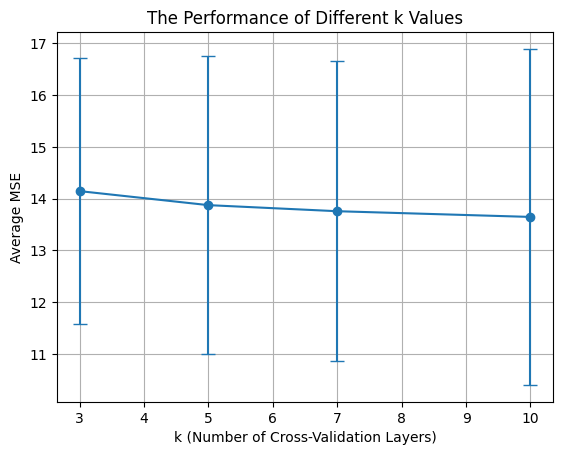

In [26]:
from sklearn.metrics import make_scorer
# Random Forest modeli
X_full = player_df_cleaned[player_df_columns]
y_column = player_performance_ratios['Kill_ratio'] # en iyi sonuç aldığımız ve en önemli kolonu örnek olarak aldık 
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Denenecek k değerleri
k_values = [3,5,7,10]

# Performans skorlarını saklamak için liste
cv_scores = []

# K değerleri için çapraz doğrulama
for k in k_values:
    # Cross-validation skorları (neg_mean_squared_error kullanıyoruz)
    scores = cross_val_score(
        rf_model, X_full, y_column, cv=k, scoring=make_scorer(mean_squared_error, greater_is_better=False)
    )
    
    # Negatif MSE'nin ortalamasını ve standart sapmasını al
    mean_score = -np.mean(scores)  # Negatiften kurtulmak için işaret değiştiriyoruz
    std_score = np.std(scores)
    cv_scores.append((k, mean_score, std_score))

cv_results = pd.DataFrame(cv_scores, columns=['k', 'Mean MSE', 'Std MSE'])
cv_results.sort_values(by='Mean MSE', inplace=True)

# En iyi k değeri
best_k = cv_results.iloc[0]['k']
print(f"Best k value: {best_k}")

# Sonuçları görselleştirme
import matplotlib.pyplot as plt

plt.errorbar(cv_results['k'], cv_results['Mean MSE'], yerr=cv_results['Std MSE'], fmt='o-', capsize=5)
plt.title("The Performance of Different k Values")
plt.xlabel("k (Number of Cross-Validation Layers)")
plt.ylabel("Average MSE")
plt.grid()
plt.show()

### Random Forest

In [18]:
best_k=10
X_full = player_df_cleaned[player_df_columns]
# RandomForestRegressor modelini kullanmak
for idx, column in enumerate(target_columns):
    y_column = player_performance_ratios[column]
    
    # X (özellikler) ve y (hedef) verilerini ayıralım
    X = X_full.drop(columns=[X_full.columns[idx]])
    
    # Cross-validation ile modelin değerlendirilmesi
    model_random_cross = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Cross-validation ile MSE hesaplamak
    # 'scoring' parametresini 'neg_mean_squared_error' olarak ayarlıyoruz, çünkü negative MSE kullanılır
    cv_scores = cross_val_score(model_random_cross, X, y_column, cv=best_k, scoring='neg_mean_squared_error')
    
    # CV sonuçları (negatif MSE) döndürülecek, bu yüzden pozitif hale getirelim
    cv_scores = -cv_scores  # Negatif olduğu için çeviriyoruz
    
    # Ortalama MSE'yi hesaplayalım
    mean_cv_mse = np.mean(cv_scores)
    mean_cv_rmse = np.sqrt(mean_cv_mse)
    mean_cv_mae = np.mean([mean_absolute_error(y_column, model_random_cross.fit(X, y_column).predict(X)) for _ in range(5)])  # Ortalama MAE hesaplaması için bir yöntem
    mean_cv_r2 = np.mean([r2_score(y_column, model_random_cross.fit(X, y_column).predict(X)) for _ in range(5)])

    # Çapraz doğrulama sonuçlarını yazdıralım
    print(f'Target column {column}, cross-validation results:')
    print(f"Mean Squared Error (MSE) - Cross-validation: {mean_cv_mse}")
    print(f"Root Mean Squared Error (RMSE) - Cross-validation: {mean_cv_rmse}")
    print(f"Mean Absolute Error (MAE) - Cross-validation: {mean_cv_mae}")
    print(f"R-squared (R²) - Cross-validation: {mean_cv_r2}")
    print("-" * 50)

Target column Kill_ratio, cross-validation results:
Mean Squared Error (MSE) - Cross-validation: 14.759673879320786
Root Mean Squared Error (RMSE) - Cross-validation: 3.8418320993141784
Mean Absolute Error (MAE) - Cross-validation: 0.9388893791943268
R-squared (R²) - Cross-validation: 0.9821602270851685
--------------------------------------------------
Target column Errors_ratio, cross-validation results:
Mean Squared Error (MSE) - Cross-validation: 32.07326259490925
Root Mean Squared Error (RMSE) - Cross-validation: 5.663326107060166
Mean Absolute Error (MAE) - Cross-validation: 1.353427676550904
R-squared (R²) - Cross-validation: 0.9726703824858778
--------------------------------------------------
Target column Total Attacks_ratio, cross-validation results:
Mean Squared Error (MSE) - Cross-validation: 12.03435452883876
Root Mean Squared Error (RMSE) - Cross-validation: 3.469056720325968
Mean Absolute Error (MAE) - Cross-validation: 0.895677169994763
R-squared (R²) - Cross-validatio

### MLP Model

In [17]:
best_k=10
best_hidden_layer_size=100
from sklearn.neural_network import MLPRegressor
X_full = player_df_cleaned[player_df_columns]

# RandomForestRegressor modelini kullanarak her hedef kolon için model eğitelim
for idx, column in enumerate(target_columns):
    y_column = player_performance_ratios[column]
    
    # X (özellikler) ve y (hedef) verilerini ayıralım
    X = X_full.drop(columns=[X_full.columns[idx]])
    
    # Yapay Sinir Ağı modelini (MLP) oluşturun
    model_mlp_cross = MLPRegressor(hidden_layer_sizes=(best_hidden_layer_size,), max_iter=1000, random_state=42) 

    cv_scores = cross_val_score(model_mlp_cross, X, y_column, cv=best_k, scoring='neg_mean_squared_error')
    
    # CV sonuçları (negatif MSE) döndürülecek, bu yüzden pozitif hale getirelim
    cv_scores = -cv_scores  # Negatif olduğu için çeviriyoruz
    
    # Ortalama MSE'yi hesaplayalım
    mean_cv_mse = np.mean(cv_scores)
    mean_cv_rmse = np.sqrt(mean_cv_mse)
    mean_cv_mae = np.mean([mean_absolute_error(y_column, model_mlp_cross.fit(X, y_column).predict(X)) for _ in range(5)])  # Ortalama MAE hesaplaması için bir yöntem
    mean_cv_r2 = np.mean([r2_score(y_column, model_mlp_cross.fit(X, y_column).predict(X)) for _ in range(5)])

    # Çapraz doğrulama sonuçlarını yazdıralım
    print(f'Target column {column}, cross-validation results:')
    print(f"Mean Squared Error (MSE) - Cross-validation: {mean_cv_mse}")
    print(f"Root Mean Squared Error (RMSE) - Cross-validation: {mean_cv_rmse}")
    print(f"Mean Absolute Error (MAE) - Cross-validation: {mean_cv_mae}")
    print(f"R-squared (R²) - Cross-validation: {mean_cv_r2}")
    print("\n")

Target column Kill_ratio, cross-validation results:
Mean Squared Error (MSE) - Cross-validation: 13.008074222956518
Root Mean Squared Error (RMSE) - Cross-validation: 3.6066707949238337
Mean Absolute Error (MAE) - Cross-validation: 2.338106215686192
R-squared (R²) - Cross-validation: 0.8944492460975468


Target column Errors_ratio, cross-validation results:
Mean Squared Error (MSE) - Cross-validation: 29.452267268251767
Root Mean Squared Error (RMSE) - Cross-validation: 5.426994312531732
Mean Absolute Error (MAE) - Cross-validation: 3.3607676873062315
R-squared (R²) - Cross-validation: 0.8339865737361418


Target column Total Attacks_ratio, cross-validation results:
Mean Squared Error (MSE) - Cross-validation: 11.434523985588612
Root Mean Squared Error (RMSE) - Cross-validation: 3.3814972993614254
Mean Absolute Error (MAE) - Cross-validation: 2.349824844386011
R-squared (R²) - Cross-validation: 0.8990471057623362


Target column Hit Pct_x, cross-validation results:
Mean Squared Error (

### SVM 

In [19]:
from sklearn.svm import SVR

X_full = player_df_cleaned[player_df_columns]

# RandomForestRegressor modelini kullanarak her hedef kolon için model eğitelim
for idx, column in enumerate(target_columns):
    y_column = player_performance_ratios[column]
    
    # X (özellikler) ve y (hedef) verilerini ayıralım
    X = X_full.drop(columns=[X_full.columns[idx]])  # Her hedef kolonu çıkararak X oluşturuyoruz
    
    # Veriyi normalize etme (SVM modelinin genellikle verilerin ölçeklenmesine ihtiyacı vardır)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Linear SVM modelini oluşturun
    model_svm_cross = SVR(kernel='rbf')# en iyi bu gelmişti
    
    cv_scores = cross_val_score(model_svm_cross, X, y_column, cv=best_k, scoring='neg_mean_squared_error')
    
    # CV sonuçları (negatif MSE) döndürülecek, bu yüzden pozitif hale getirelim
    cv_scores = -cv_scores  # Negatif olduğu için çeviriyoruz

    # Ortalama MSE'yi hesaplayalım
    mean_cv_mse = np.mean(cv_scores)
    mean_cv_rmse = np.sqrt(mean_cv_mse)
    mean_cv_mae = np.mean([mean_absolute_error(y_column, model_svm_cross.fit(X, y_column).predict(X)) for _ in range(5)])  # Ortalama MAE hesaplaması için bir yöntem
    mean_cv_r2 = np.mean([r2_score(y_column, model_svm_cross.fit(X, y_column).predict(X)) for _ in range(5)])

    # Çapraz doğrulama sonuçlarını yazdıralım
    print(f'Target column {column}, cross-validation results:')
    print(f"Mean Squared Error (MSE) - Cross-validation: {mean_cv_mse}")
    print(f"Root Mean Squared Error (RMSE) - Cross-validation: {mean_cv_rmse}")
    print(f"Mean Absolute Error (MAE) - Cross-validation: {mean_cv_mae}")
    print(f"R-squared (R²) - Cross-validation: {mean_cv_r2}")
    print("\n")

Target column Kill_ratio, cross-validation results:
Mean Squared Error (MSE) - Cross-validation: 16.094254323985925
Root Mean Squared Error (RMSE) - Cross-validation: 4.0117644900948415
Mean Absolute Error (MAE) - Cross-validation: 2.7553536230787286
R-squared (R²) - Cross-validation: 0.8630945288212135


Target column Errors_ratio, cross-validation results:
Mean Squared Error (MSE) - Cross-validation: 63.961180187274465
Root Mean Squared Error (RMSE) - Cross-validation: 7.997573393678514
Mean Absolute Error (MAE) - Cross-validation: 5.758845580247199
R-squared (R²) - Cross-validation: 0.6092974434820263


Target column Total Attacks_ratio, cross-validation results:
Mean Squared Error (MSE) - Cross-validation: 15.32635158550876
Root Mean Squared Error (RMSE) - Cross-validation: 3.914888451221664
Mean Absolute Error (MAE) - Cross-validation: 2.817833270946113
R-squared (R²) - Cross-validation: 0.8558002472756607


Target column Hit Pct_x, cross-validation results:
Mean Squared Error (MS

# Save The Model

In [ ]:
# save edeceğin modeli çalıltırırken bunu ekle
    # Dosya yolu
    file_path = f'pkl_files_regression/randomForest_model_{X_full.columns[idx]}.pkl'

    # Klasör yoksa oluştur
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    # Modeli kaydet
    with open(file_path, 'wb') as f:
        pickle.dump(model_random_original, f)